## Plot maker! 
_______________________________________________

In [21]:
#############################
# Initilize 
#############################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize

# Set global plot params


fontsize = 10
figsize = (8,6)
dpi = 300

plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2



plt.style.use('default')
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'





In [37]:
#########################
# Read in data
########################

#Specify working directory
path = '/Users/bbonine/ou/research/corr_func/figures/02_20_21_data_log/'


# Read in output files
centers,corr,sig,fields = np.loadtxt(path+'out.txt', skiprows = 1, unpack = True)

centers = centers[7:]
corr = corr[7:]
sig = sig[7:]
fields= fields[7:]
#ratios = np.genfromtxt(path1+'ratio.txt',delimiter = ',')

# Select only positive values to use in the fit
pos_vals = np.where(corr > 0)[0]
print("Bins: " +str(len(centers)))
print("Values used: " +str(len(pos_vals)))


x = centers[pos_vals]
y = corr[pos_vals]
y_err = sig[pos_vals]

Bins: 12
Values used: 9


In [38]:
####################
# Fit the data
#####################
#convert to log

logx = np.log10(x)
logy = np.log10(y)
logyerr = (1/2.3)* y_err / y

#Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

# define our line fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p,x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args = (logx, logy, logyerr), full_output = 1)
pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**(pfinal[0])

indexErr = np.sqrt(covar[1][1])
ampErr = np.sqrt(covar[0][0]) * amp



[ 0.88033275 -1.14237177]
[[ 0.33015431 -0.15972844]
 [-0.15972844  0.07813574]]


(10, 650)

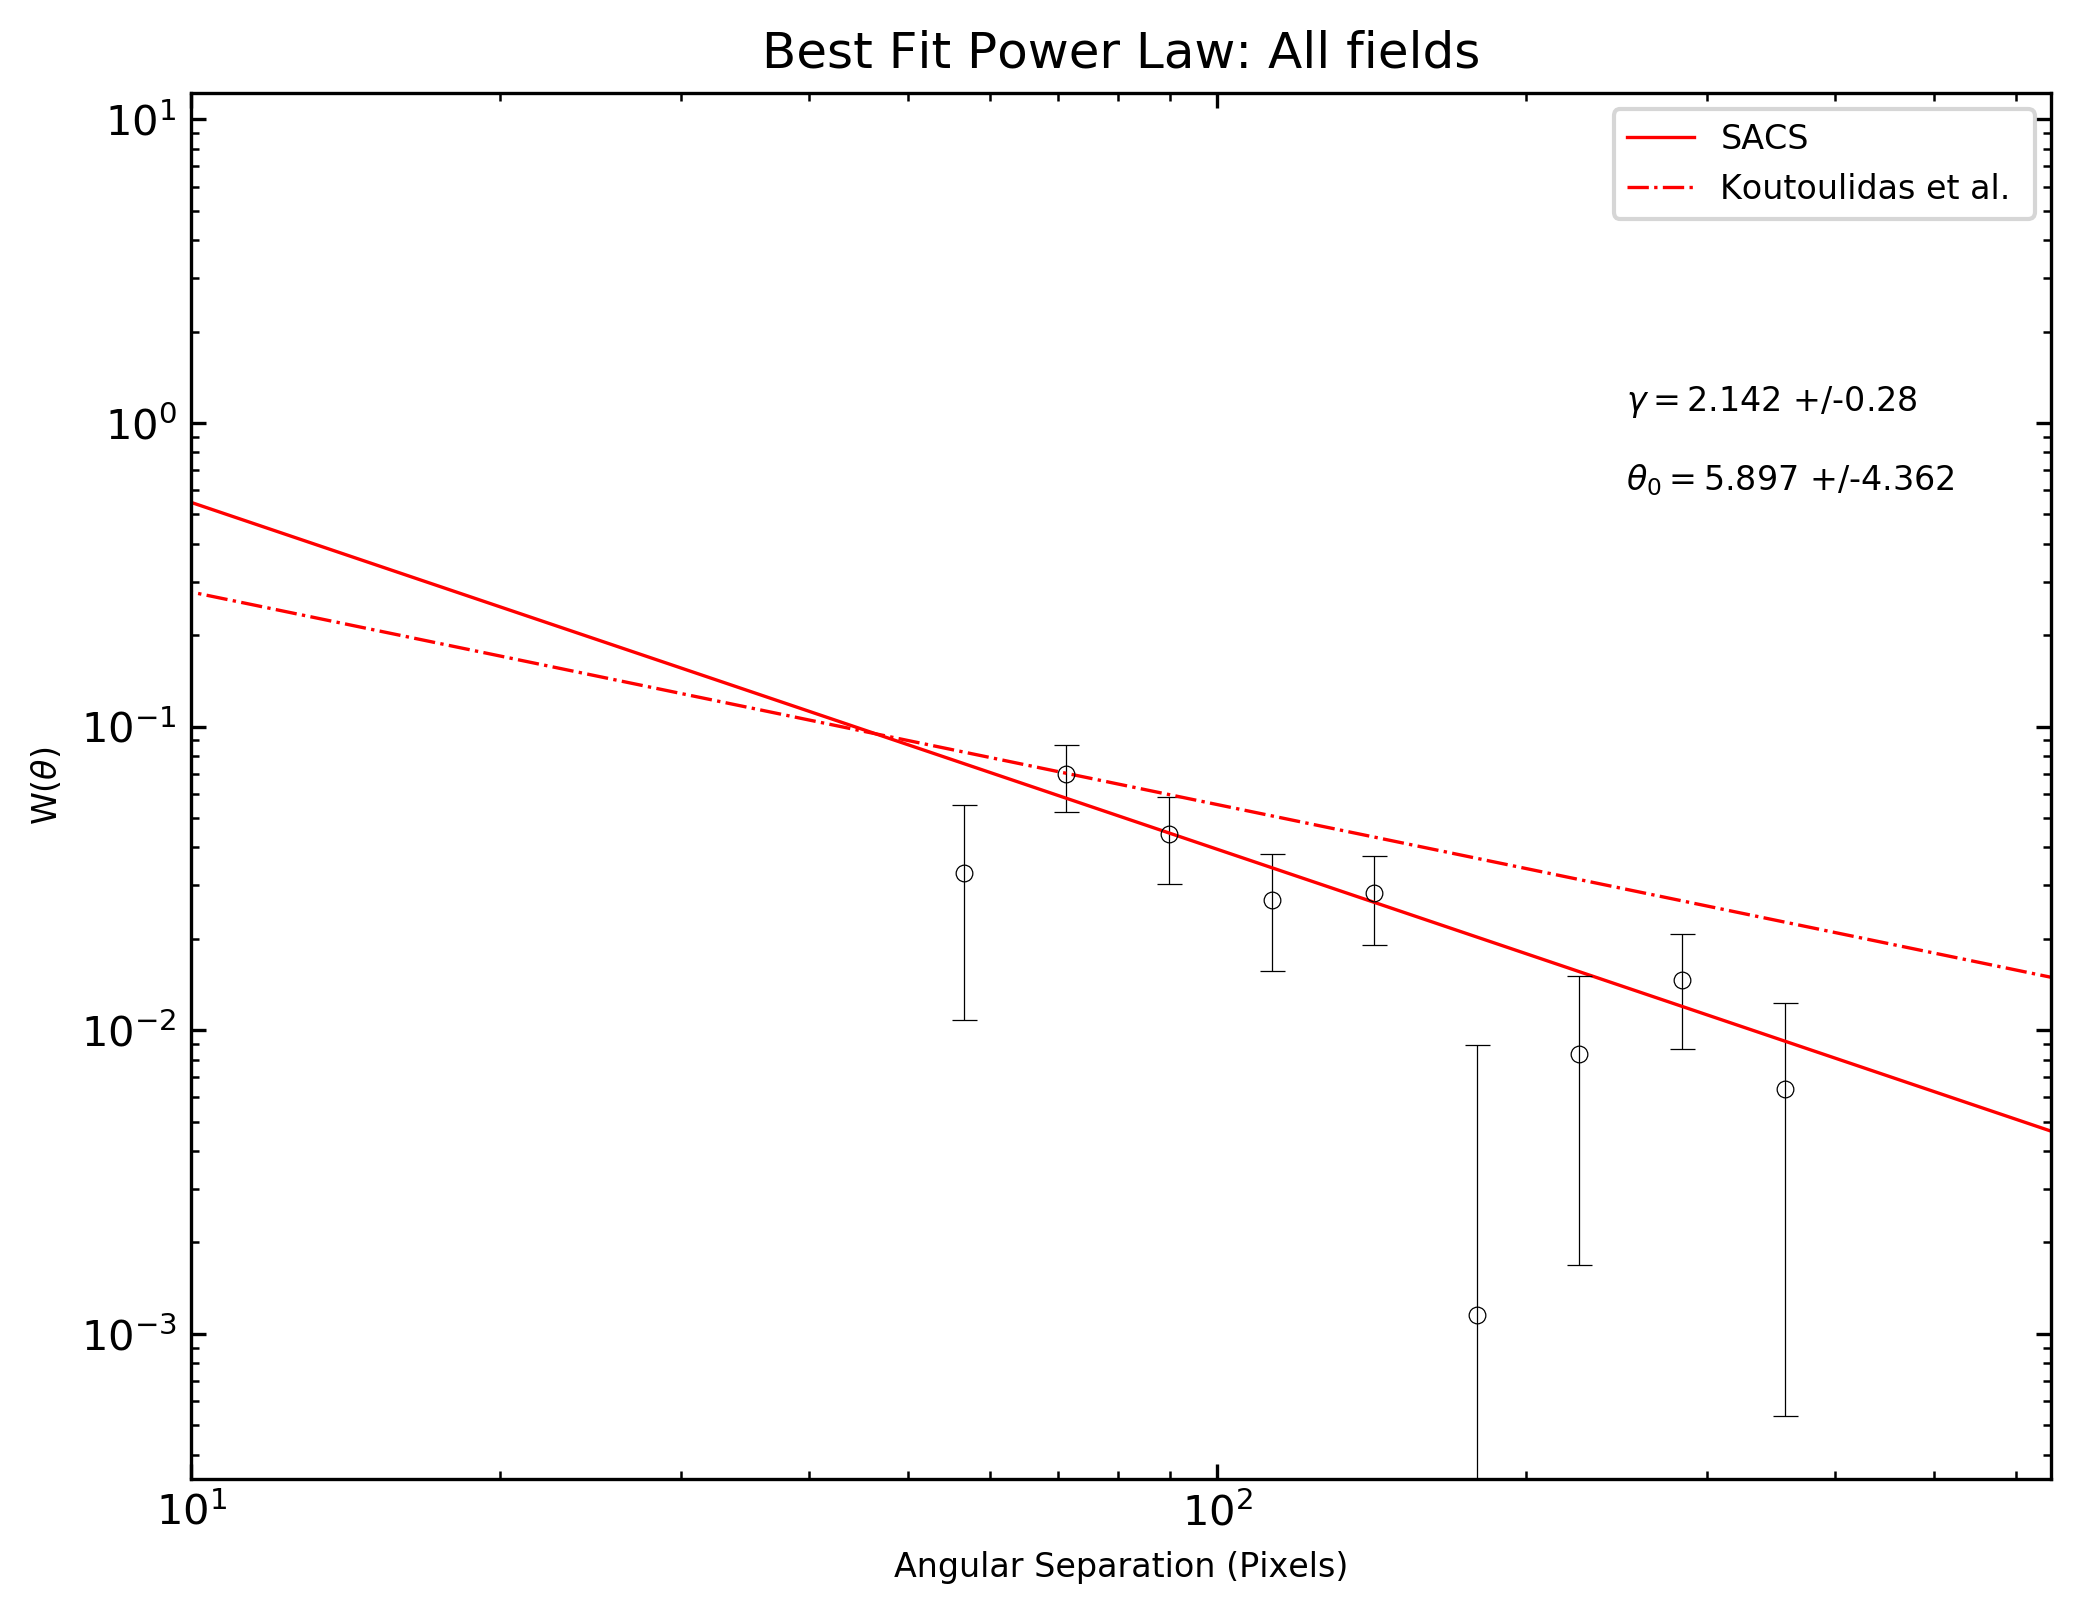

In [39]:
##################
# Plot 
##################

x_fit = np.linspace(1,700,num = 1000)


'''
%%%%%%%%%%%%%%%%%%
Linear Scale Fit
%%%%%%%%%%%%%%%%%%
'''

plt.figure(figsize = [8,6], dpi = 300)

#Fit
plt.plot(x_fit,powerlaw(x_fit,amp,index), label = 'SACS', color = 'red', linewidth = 0.8) # fit
plt.errorbar(centers,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 4, mew = 0.3, mfc = 'none', capsize = 3, linewidth = 0.8) # data
# Koutilidas Result
plt.plot(x_fit,(1/1.6)**(1-1.7)*(x_fit)**(1-1.7), label = 'Koutoulidas et al. ', color = 'red', linewidth = 0.8, linestyle = '-.')
# Params
plt.title('Best Fit Power Law: All fields')
plt.xlabel('Angular Separation (Pixels)', fontsize = 8)
plt.ylabel(r'W$(\theta)$', fontsize = 8)
plt.legend(fontsize = 8)

plt.xscale('log')
plt.yscale('log')
plt.text(250,0.6, r'$\theta_0 = $' + str(np.around(1/(amp**(1/index)),3)) + " +/-" + str(np.around(ampErr,3)), fontsize = 8)
plt.text(250,1.1, r'$\gamma = $' + str(np.around(1-index,3)) + " +/-" + str(np.around(indexErr,3)),fontsize = 8)

plt.xlim(10,650)
#plt.savefig(path+ 'fit_lin1.png')
#plt.close()

In [48]:
print(np.median((y_err/y))/3)


0.13884341772470257


array([0.03303464, 0.06955688, 0.04437383, 0.02692512, 0.02824679,
       0.00115287, 0.00835062, 0.01465797, 0.00640329])